In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


from lerobot.policies.smolandfast.tokenizer import Autoencoder
from torch.optim.lr_scheduler import CosineAnnealingLR

from pathlib import Path
from tqdm import tqdm
import torch
from lerobot.datasets.utils import cycle

from lerobot.configs.types import FeatureType
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.smolandfast.configuration_smolandfast import SMOLANDFASTConfig

import matplotlib.pyplot as plt

from lerobot.processor.normalize_processor import NormalizerProcessorStep
from lerobot.configs.types import FeatureType, NormalizationMode, PolicyFeature

/lerobot-experiments/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_directory = Path("outputs/train/example_pusht")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda")

In [3]:
DATASET_PATH = "lerobot/pusht"

dataset_metadata = LeRobotDatasetMetadata(DATASET_PATH)
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

cfg = SMOLANDFASTConfig(input_features=input_features,
                        output_features=output_features)

delta_timestamps = {
        "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
    }

# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset(DATASET_PATH, delta_timestamps=delta_timestamps)

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=32,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)
dl_iter = cycle(dataloader)

def _build_min_max_normalizer(dataset: LeRobotDataset) -> NormalizerProcessorStep:
    action_shape = tuple(dataset.meta.shapes["action"])
    features = {"action": PolicyFeature(type=FeatureType.ACTION, shape=action_shape)}
    norm_map = {FeatureType.ACTION: NormalizationMode.MIN_MAX}
    normalizer = NormalizerProcessorStep.from_lerobot_dataset(dataset, features, norm_map)
    return normalizer

normalizer = _build_min_max_normalizer(dataset)

def preprocess(raw_batch):
    return normalizer._normalize_action(torch.as_tensor(raw_batch['action'], dtype=torch.float32), inverse=False).cpu()

In [4]:
def _iterate_normalized_actions(
    dataset: LeRobotDataset,
    normalizer: NormalizerProcessorStep,
    n_steps: int | None = None,
):
    if n_steps is None:
        n_steps = len(dataset)

    for i in tqdm(range(n_steps), desc="Iterating dataset for actions"):
        a = dataset[i]["action"].unsqueeze(0)  # shape: (horizon, action_dim)
        a_norm = normalizer._normalize_action(torch.as_tensor(a, dtype=torch.float32), inverse=False)
        yield a_norm
        
actions_iter = _iterate_normalized_actions(dataset, normalizer, n_steps=1000)



In [33]:
from lerobot.policies.smolandfast.tokenizer_with_diffusion import DiffusionAE

hyperparameters = {
    # encoder
    "ratios": [2,],
    "num_lstm_layers": 2,
    "horizon": 8,

    "encoded_dim": 2,
    "emdedding_dim": 128,
    "vocab_size": 512,

    # diffusion
    "n_layer": 2,
    "n_head": 4,
    "n_emb": 128,
    "n_cond_layers": 1,

    "num_train_timesteps": 1000,
    "prediction_type": 'epsilon',
}

diff_model = DiffusionAE(**hyperparameters)

checkpoint_path = "diffusion_trans_small_4.pth"
checkpoint = torch.load(checkpoint_path)
diff_model.load_state_dict(checkpoint['model_state_dict'])
diff_model.eval()

/lerobot-experiments/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


DiffusionAE(
  (encoder): EncoderTransformer(
    (patch_emb): Conv1d(2, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (quantizer): ResidualVectorQuantizer(
    (vq): ResidualVectorQu

Iterating dataset for actions:   0%|          | 0/1000 [00:02<?, ?it/s]


tensor([[[103, 112],
         [103,  19],
         [103, 480],
         [103, 352]]])


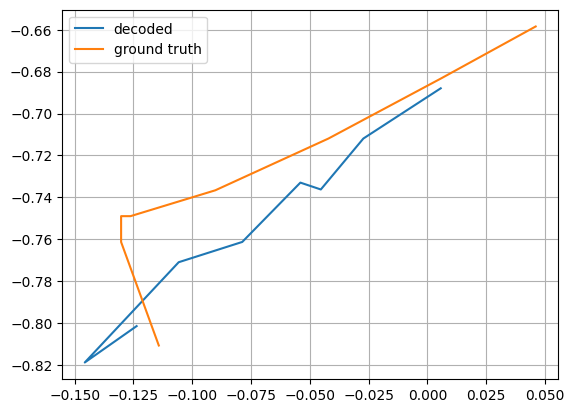

In [46]:
actions_iter = _iterate_normalized_actions(dataset, normalizer, n_steps=1000)
act = next(actions_iter)

encoded = diff_model.encode(act)
decoded = diff_model.decode(encoded, num_inference_steps=10)

print(encoded)
# decoded2, encoded2, _, noise = diff_model(act)
# decoded2 = decoded2.cpu().detach().numpy()

plt.plot(decoded[0, :, 0], decoded[0, :, 1], label="decoded")
# plt.plot(decoded2[0, :, 0], decoded2[0, :, 1], label="decoded2")
plt.plot(act[0, :, 0], act[0, :, 1], label="ground truth")

plt.legend()
plt.grid()
plt.show()

In [47]:
print("decoded", decoded)
print("True action", act)

decoded tensor([[[-0.1237, -0.8014],
         [-0.1457, -0.8188],
         [-0.1058, -0.7710],
         [-0.0787, -0.7613],
         [-0.0540, -0.7330],
         [-0.0453, -0.7362],
         [-0.0272, -0.7119],
         [ 0.0057, -0.6879]]])
True action tensor([[[-0.1142, -0.8107],
         [-0.1303, -0.7613],
         [-0.1303, -0.7490],
         [-0.1263, -0.7490],
         [-0.0902, -0.7366],
         [-0.0421, -0.7119],
         [ 0.0060, -0.6831],
         [ 0.0461, -0.6584]]])


In [25]:
def calc_rmse(iterator, coder):
    res = 0
    for act in iterator:
        with torch.no_grad():
            # decoded_actions, _, _ = coder(act)
            encoded = coder.encode(act)
            decoded = coder.decode(encoded, num_inference_steps=100)

            error: torch.tensor = torch.sqrt((decoded - act)**2)
            res += error.sum(dim=1)
    return res

In [26]:
actions_iter = _iterate_normalized_actions(dataset, normalizer, n_steps=1000)

print(calc_rmse(actions_iter, diff_model))

Iterating dataset for actions:  34%|███▍      | 345/1000 [02:37<05:22,  2.03it/s]

KeyboardInterrupt: 